<h1>Machine Learning for Predicting Loan Default</h1>


<b>Author: Jamie Fraser<b>

This notebook was completed as part of the Machine Learning with Python course in fulfilment of the requirements of the IBM Data Science Professional Certificate on Coursera. The project was completed on 19 July 2021. The purpose of these exercises are to generate 4 different machine learning models to assess loan default, evaluate the models, then obtain the results that show which model is the most efficient in predicting default.

<b> Original work begins at Line 21 <b>

Lines 1-19 of this notebook were given by course instructors.

In [1]:
#The first section of this notebook was given by course instructors
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
#Download the dataset
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-07-19 13:53:17--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-07-19 13:53:17 (191 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [6]:
#Data visualization and pre-processing
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


In [7]:
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



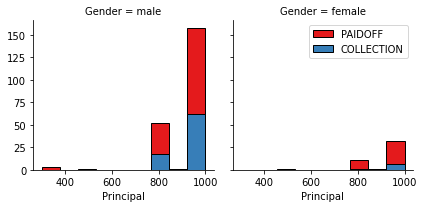

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

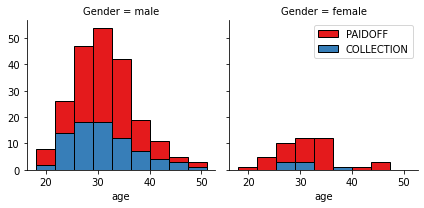

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

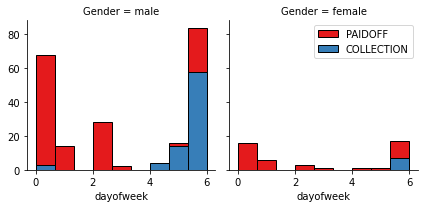

In [10]:
#Pre-processing feature selection/extraction
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [17]:
#Define feature set
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# <u> Original Work Begins Below <u>


## K Nearest Neighbor(KNN)

In [21]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

#Initialize open arrays to store results
Kclass = 20
mean_acc=np.zeros((Kclass-1))
std_acc=np.zeros((Kclass-1))

#Loop over different values of k to train model and obtain predictions
for n in range(1, Kclass):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.69230769, 0.67307692, 0.76923077, 0.69230769, 0.74038462,
       0.68269231, 0.74038462, 0.67307692, 0.75      , 0.72115385,
       0.78846154, 0.72115385, 0.77884615, 0.75      , 0.76923077,
       0.75961538, 0.77884615, 0.76923077, 0.77884615])

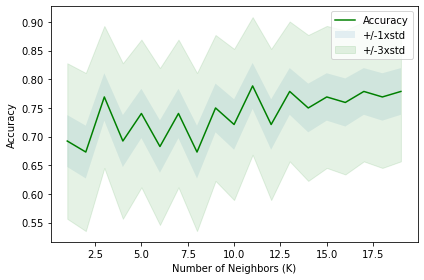

The best accuracy was with 0.7884615384615384 with k= 11


In [25]:
#Plot accuracy by the value of k
plt.plot(range(1,Kclass), mean_acc, 'g')
plt.fill_between(range(1,Kclass), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10)
plt.fill_between(range(1,Kclass), mean_acc-3*std_acc, mean_acc+3*std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy', '+/-1xstd', '+/-3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

#Print final result
print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

## Decision Tree


In [26]:
#Import required packages
from sklearn.tree import DecisionTreeClassifier

#Check dimensions of train and test datasets, from last exercise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

#Initialize the model
LoanTree=DecisionTreeClassifier(criterion="entropy", max_depth=10)
LoanTree.fit(X_train, y_train)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [27]:
#Generate predictions
predTree=LoanTree.predict(X_test)
print(predTree[0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |           py37_1          42 KB  anaconda
    ------------------------------------------------------------
                                           Total:          42 KB

The following NEW packages will be INSTALLED:

  pydotplus          anaconda/linux-64::pydotplus-2.0.2-py37_1



pydotplus-2.0.2      | 42 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
DecisionTree's Accuracy: 0.7307692307692307


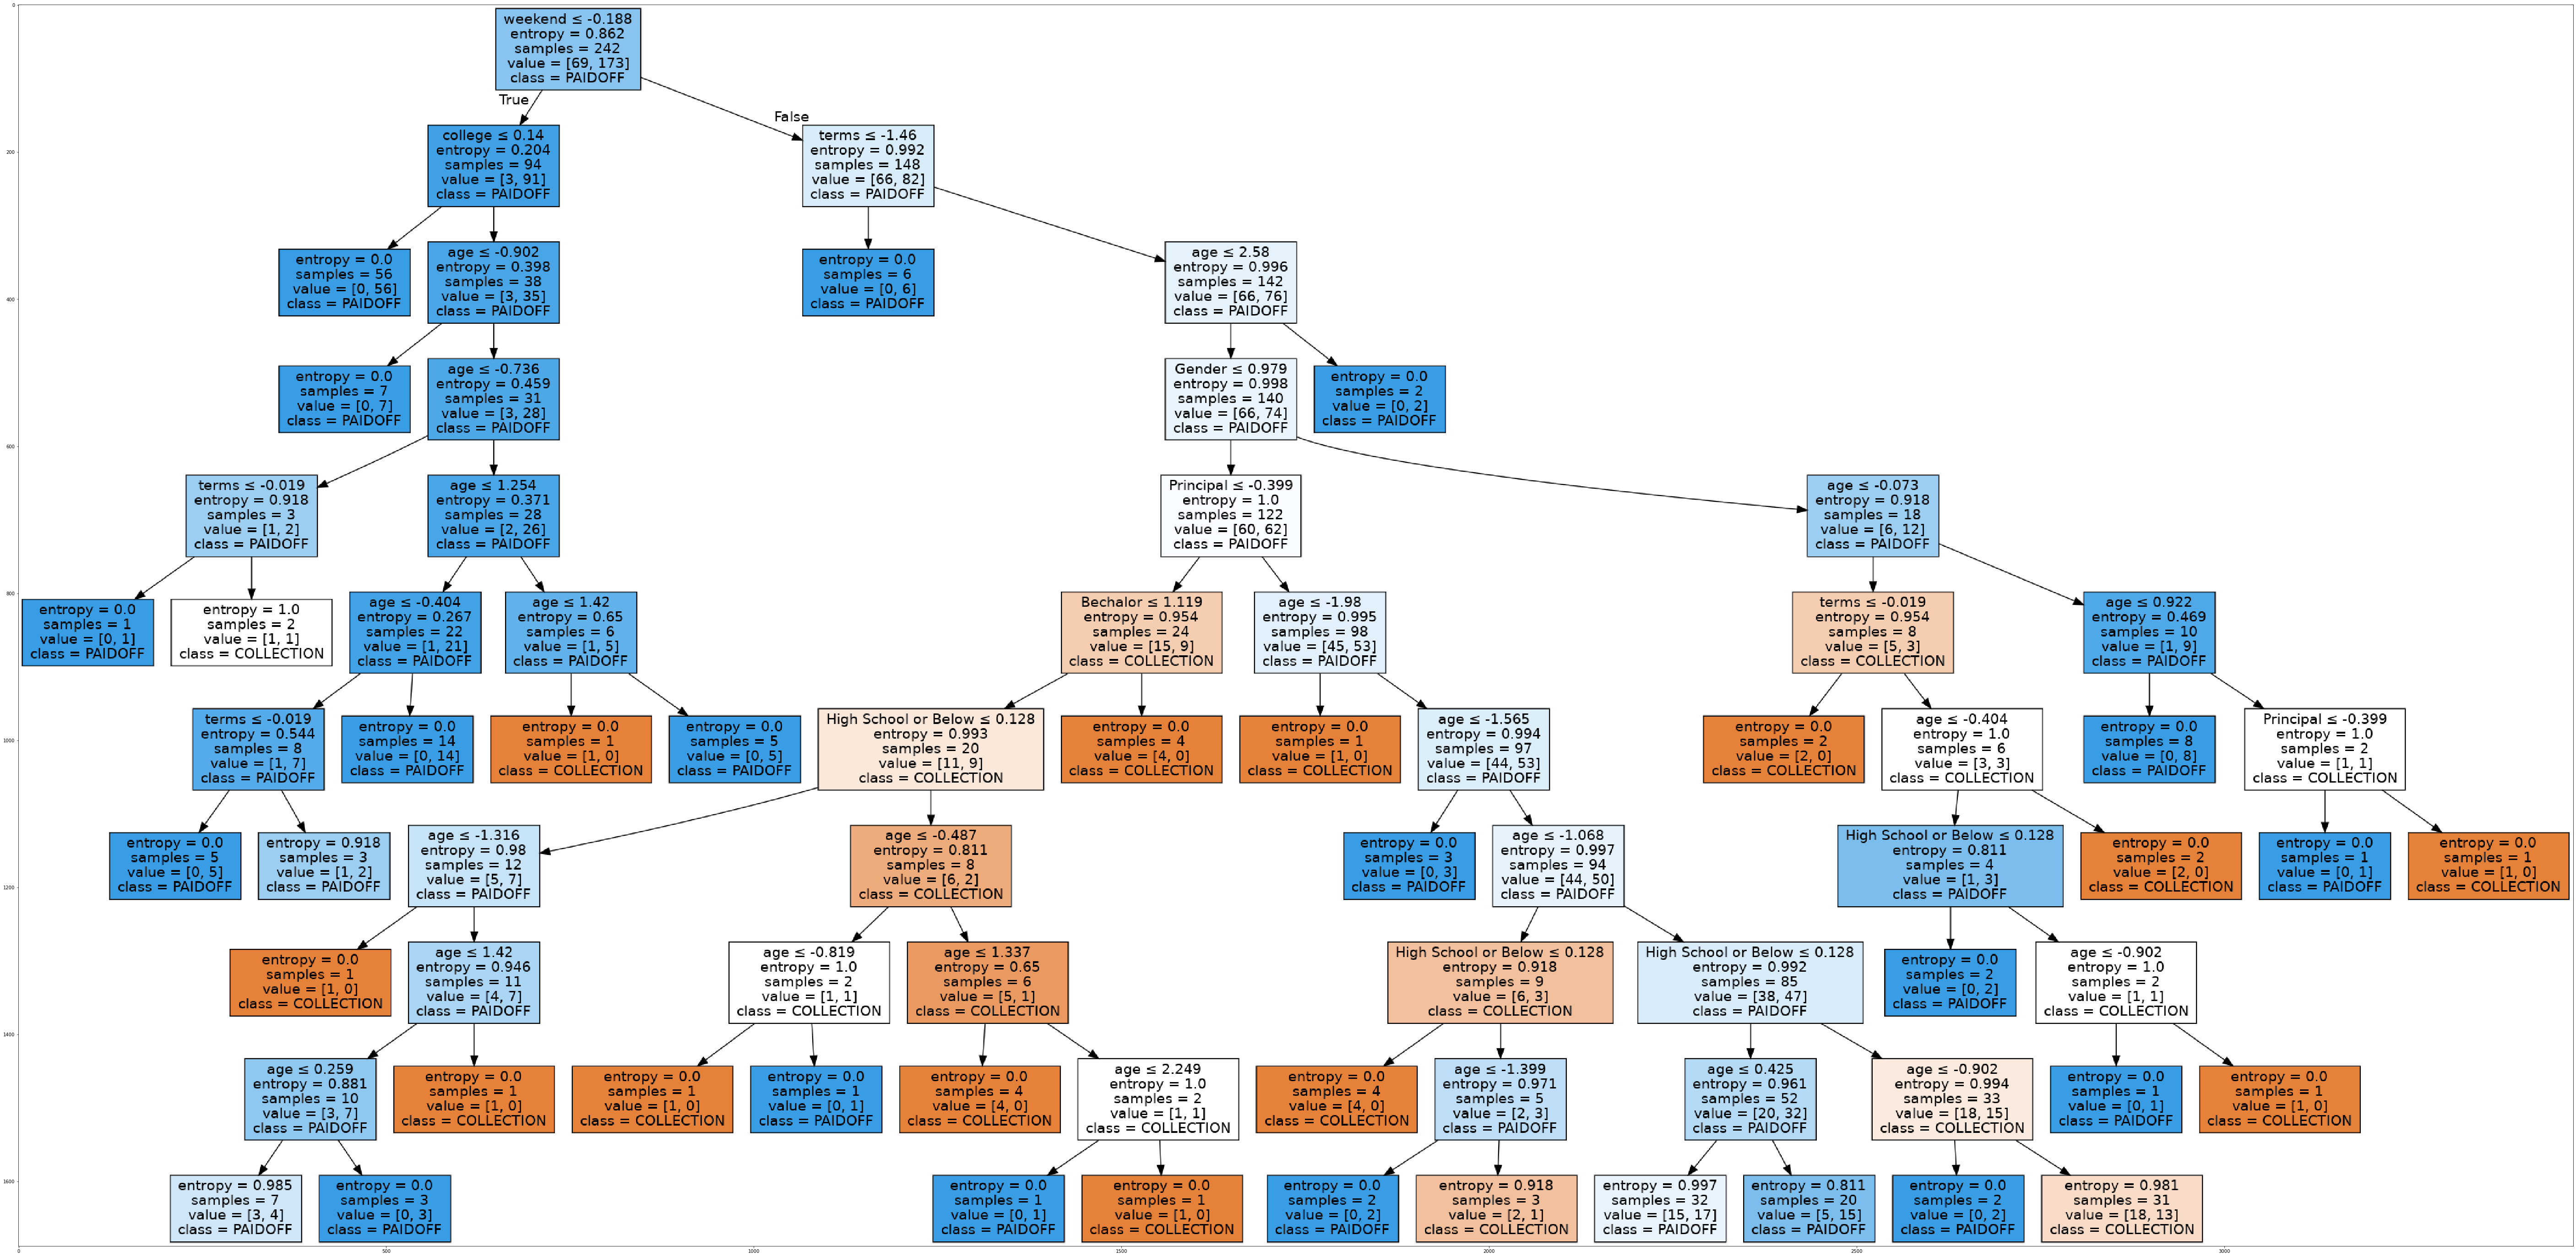

In [28]:
#Visualize
!conda install -c anaconda pydotplus -y
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data=StringIO()
filename="Loantree.png"
featureNames=Feature.columns
out=tree.export_graphviz(LoanTree, feature_names=featureNames, out_file=dot_data, class_names=np.unique(y_train), filled=True, special_characters=True, rotate=False)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img=mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')

#Obtain accuracy score
print("DecisionTree's Accuracy:", metrics.accuracy_score(y_test, predTree))

## Support Vector Machine


In [29]:
#Import required packages
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Check dimensions of train and test datasets, from first exercise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

#Initialize SVM model
clf=svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
yhat=clf.predict(X_test)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [33]:
#Evaluate SVM model
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.25      0.24      0.24        17
     PAIDOFF       0.85      0.86      0.86        87

    accuracy                           0.76       104
   macro avg       0.55      0.55      0.55       104
weighted avg       0.75      0.76      0.76       104

Confusion matrix, without normalization
[[ 4 13]
 [12 75]]


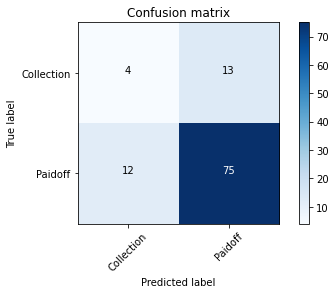

In [34]:
#Compute and plot confusion matrix
cnf_matrix=confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Collection', 'Paidoff'], normalize=False, title='Confusion matrix')

## Logistic Regression


In [35]:
#Import required packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Check dimensions of train and test datasets, from first exercise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [36]:
#Initialize Logistic Regression model
LR=LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
yhat=LR.predict(X_test)
yhat_prob=LR.predict_proba(X_test)

[[ 6 11]
 [10 77]]
              precision    recall  f1-score   support

  COLLECTION       0.38      0.35      0.36        17
     PAIDOFF       0.88      0.89      0.88        87

    accuracy                           0.80       104
   macro avg       0.62      0.62      0.62       104
weighted avg       0.79      0.80      0.80       104

Confusion matrix, without normalization
[[ 6 11]
 [10 77]]


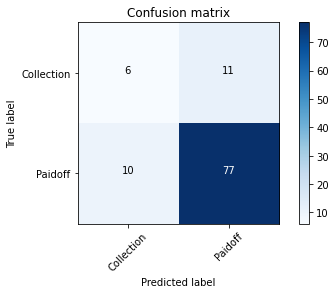

In [39]:
#Visualize confusion matrix
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))

cnf_matrix=confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Collection', 'Paidoff'], normalize=False, title='Confusion matrix')

## Model Evaluation using Test set


In [40]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-07-19 14:29:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-07-19 14:29:35 (88.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [48]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [49]:
#Preprocessing and one hot encoding
test_df['effective_date']=pd.to_datetime(test_df['effective_date'])
test_df['due_date']=pd.to_datetime(test_df['due_date'])
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['dayofweek']=test_df['effective_date'].dt.dayofweek
test_df['weekend']=test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [60]:
#Set feature set
Feature=test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
Feature=pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis=1, inplace=True)
X=Feature
X=preprocessing.StandardScaler().fit(X).transform(X)
y=test_df['loan_status'].values

##Obtain F1 and jaccard scores for each of the 4 models
#KNN
yhat_knn=neigh.predict(X)
f1_knn=f1_score(y, yhat_knn, average='weighted')
jaccard_knn=jaccard_score(y, yhat_knn, pos_label='PAIDOFF')

#Decision Tree
predTree=LoanTree.predict(X)
f1_dec=f1_score(y, predTree, average='weighted')
jaccard_dec=jaccard_score(y, predTree, pos_label='PAIDOFF')

#SVM
yhat_svm=clf.predict(X)
f1_svm=f1_score(y, yhat_svm, average='weighted')
jaccard_svm=jaccard_score(y, yhat_svm, pos_label='PAIDOFF')

#Logistic Regression
yhat_lr=LR.predict(X)
f1_lr=f1_score(y, yhat_lr, average='weighted')
jaccard_lr=jaccard_score(y, yhat_lr, pos_label='PAIDOFF')

yhat_lr_prob=LR.predict_proba(X)
logloss_lr=log_loss(y, yhat_lr_prob)

In [62]:
#Print results
table=pd.DataFrame([['KNN', jaccard_knn, f1_knn, 'NA'], \
                   ['Decision Tree', jaccard_dec, f1_dec, 'NA'], \
                   ['SVM', jaccard_svm, f1_svm, 'NA'], \
                   ['Logistic Regression', jaccard_lr, f1_lr, logloss_lr]])
table.columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
table

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.740000,0.728821,NA
1,Decision Tree,0.717391,0.761886,NA
2,SVM,0.720000,0.714431,NA
3,Logistic Regression,0.760000,0.743434,0.585163


## Final Results - Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.74       | 0.73        | NA      |
| Decision Tree      | 0.72       | 0.76        | NA      |
| SVM                | 0.72       | 0.71        | NA      |
| LogisticRegression | 0.76       | 0.74        | 0.59       |
